In [13]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Layer
from scipy.signal import correlate
sample_rate = 4096   # or your actual sampling rate
max_lag_ms = 10      # ±10 ms

In [14]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/LIGO/Datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# # load data and normalize it
# background = np.load('background.npz')['data']
# stds = np.std(background, axis=-1)[:, :, np.newaxis]
# background = background/stds
# background = np.swapaxes(background, 1, 2)

# bbh = np.load('bbh_for_challenge.npy')
# stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
# bbh = bbh/stds
# bbh = np.swapaxes(bbh, 1, 2)

# sglf = np.load('sglf_for_challenge.npy')
# stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
# sglf = sglf/stds
# sglf = np.swapaxes(sglf, 1, 2)
# # Create train and test datasets
# x_train, x_test, y_train, y_test = train_test_split(
#      background, background, test_size=0.2, random_state=42)

In [17]:
# load data and normalize it
# didnt swap axes, new shape is (100000, 2, 200)
background = np.load('background.npz')['data']
bbh = np.load('bbh_for_challenge.npy')
sglf = np.load('sglf_for_challenge.npy')

def correlation_feature(x):
    data = np.empty((1000,1,200))
    for i, signal in enumerate(x):
        s1 = signal[0]
        s2 = signal[1]
        correlated = correlate(s1, s2, mode='full', method='auto')[::2]
        data[i]=correlated
    x = np.concatenate((x,data),axis = 1)
    stds = np.std(x,axis=-1)[:,:,np.newaxis]
    x = x/stds
    x = np.swapaxes(x,1,2)
    return x

background = correlation_feature(background)
bbh = correlation_feature(bbh)
sglf = correlation_feature(sglf)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

SOLUTION

In [18]:
class RotaryPositionEmbedding(Layer):
    def call(self, x):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        dim_head = tf.shape(x)[2]
        half_dim = dim_head // 2

        # Compute frequencies and angles
        frequency = tf.exp(-tf.range(half_dim, dtype=tf.float32) / tf.cast(half_dim, tf.float32) * tf.math.log(10000.0))
        pos = tf.range(seq_len, dtype=tf.float32)
        angles = tf.einsum("i,j->ij", pos, frequency)

        # Create sin/cos embeddings
        sin_embed = tf.sin(angles)
        cos_embed = tf.cos(angles)

        # Reshape for broadcasting
        sin_embed = tf.reshape(sin_embed, [1, seq_len, half_dim])
        cos_embed = tf.reshape(cos_embed, [1, seq_len, half_dim])

        # Split into even/odd components
        x_reshaped = tf.reshape(x, [batch_size, seq_len, half_dim, 2])
        x_cos = x_reshaped[:, :, :, 0]
        x_sin = x_reshaped[:, :, :, 1]

        # Apply rotation
        rotated_even = x_cos * cos_embed - x_sin * sin_embed
        rotated_odd = x_sin * cos_embed + x_cos * sin_embed

        # Interleave and reshape back
        x_rotated = tf.reshape(
            tf.stack([rotated_even, rotated_odd], axis=-1),
            [batch_size, seq_len, dim_head]
        )

        return x_rotated

class Model:
    def __init__(self):
        super().__init__()

    # def positional_encoding(self, inputs):
    #     embed_size = inputs.shape[-1]
    #     input_length = inputs.shape[-2]
    #     assert embed_size % 2 == 0, 'embed_size must be even'
    #     p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
    #     pos_emb = np.empty((1,input_length, embed_size))
    #     pos_emb[0,:,::2] = np.sin(p/(10000**(i/embed_size))).T
    #     pos_emb[0,:,1::2] = np.cos(p/(10000**(i/embed_size))).T
    #     self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
    #     return inputs + self.pos_encoding[:, :input_length, :]


    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout, bottleneck_dim = 32):
        x = layers.Conv1D(filters=ff_dim, kernel_size=3, dilation_rate=5, padding='same', activation='relu')(inputs)
        x = layers.Dropout(dropout)(x)

        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        # x = BatchNormalization(epsilon=1e-6)(x)
        res = x + inputs

        # x = layers.Conv1D(filters=ff_dim, kernel_size=15,padding='same', activation="relu")(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=15, dilation_rate=1, padding='same', activation='relu')(res)
        x = layers.Dropout(dropout)(x)
        # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=15,padding='same')(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=15, dilation_rate=1, padding='same')(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        # x = BatchNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]


    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout):
        inputs = keras.Input(shape=input_shape)
        inputs = RotaryPositionEmbedding()(inputs)
        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        encoder_output = x
        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)
        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)
        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=5e-5))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(path)

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 80
num_heads = 2
ff_dim = 80
num_transformer_blocks = 4
num_dense_blocks = 2
dropout = 0.2

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=90,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 73s 63ms/step - loss: 3.6547 - val_loss: 0.5969
Epoch 2/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - loss: 0.8782 - val_loss: 0.5010
Epoch 3/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.6705 - val_loss: 0.3862
Epoch 4/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.5365 - val_loss: 0.3263
Epoch 5/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.4577 - val_loss: 0.2850
Epoch 6/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.3972 - val_loss: 0.2406
Epoch 7/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.3392 - val_loss: 0.1979
Epoch 8/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - loss: 0.2874 - val_loss: 0.1624
Epoch 9/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.2451 - val_loss: 0.1310
Epoch 10/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - loss: 0.1998 - val_loss: 0.0894
Epoch 11/50
712/712 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - loss: 0.1469 - val_loss: 0.0545
Epoch 12/50
712/712 ━━━━━━━━━━

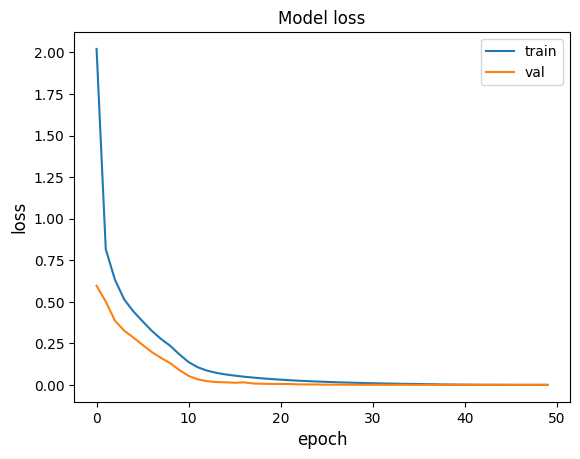

In [19]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


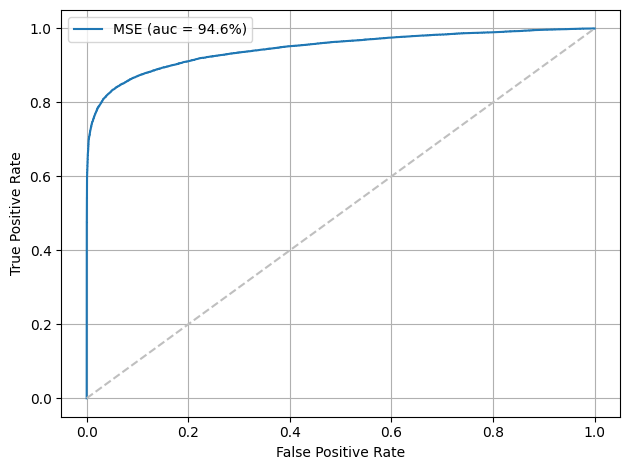

In [20]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)

    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc_loss

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh[:20000])

AUC_bbh=make_plot_roc_curves(background_test,signal_test)

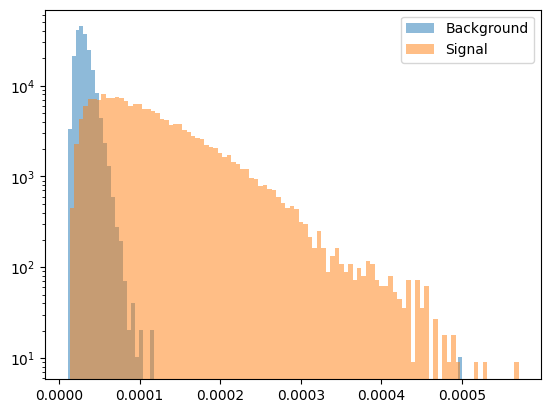

In [21]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


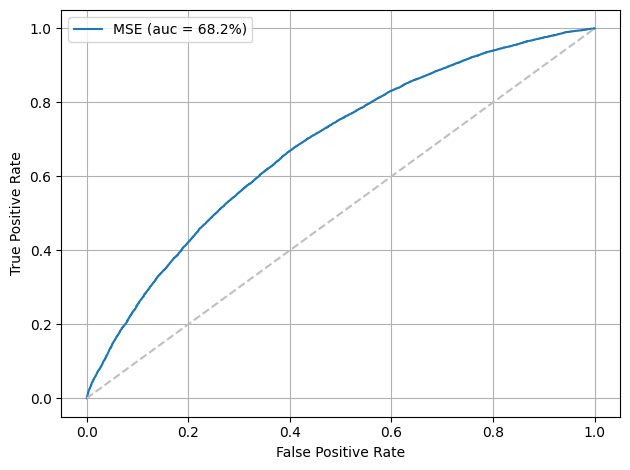

In [22]:
signal_test = autoencoder.predict(sglf[:20000])

AUC_sg=make_plot_roc_curves(background_test,signal_test)

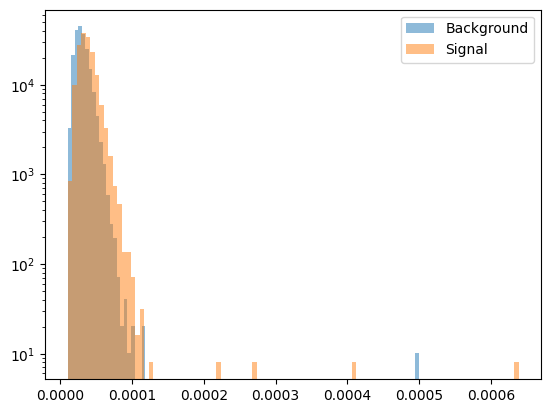

In [23]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [24]:
formatted_scoreA = f"{AUC_bbh * 100:.1f}"  # e.g., "83.4"
formatted_scoreB = f"{AUC_sg * 100:.1f}"  # e.g., "33.4"

# Combine the scores into the filename format
combined_scores = f"({formatted_scoreA})({formatted_scoreB})"

# Save the model with the combined scores in the filename
save_path = f"/content/drive/My Drive/LIGO/Datasets/TransformerHDR_model/model_{combined_scores}.keras"
autoencoder.save(save_path)